In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math as mt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as kb
import os
import time
import wandb
import sys
import random as rd

sys.path.append("..")

from AllMethods import ReversibleSymplecticNN as rs
from AllMethods import PerturbedPendulum_Methods as pp

gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [2]:
class R(tf.keras.layers.Layer):

    def __init__(self):
        super(R, self).__init__()
        
    def call(self, inputs):
        return inputs*tf.constant([[1., -1.]])

layer = R()

In [3]:
class RevPINN(tf.keras.Model):
    
    def __init__(self):
            super(RevPINN, self).__init__()
        
            self.R = R()
            
            self.A1 = tf.keras.layers.Dense(10, activation='tanh')
            self.A2 = tf.keras.layers.Dense(40, activation='tanh')
            self.A3 = tf.keras.layers.Dense(10, activation='tanh')
            self.A4 = tf.keras.layers.Dense(2, activation='tanh')
            
            #self.B1 = tf.keras.layers.Dense(55, activation='tanh')
            #self.B2 = tf.keras.layers.Dense(55, activation='tanh')
            #self.B3 = tf.keras.layers.Dense(2, activation='tanh')
            
            #self.b3 = tf.keras.layers.Dense(55, activation='tanh')
            #self.b2 = tf.keras.layers.Dense(55, activation='tanh')
            #self.b1 = tf.keras.layers.Dense(2, activation='tanh')
            
            self.a4 = tf.keras.layers.Dense(10, activation='tanh')
            self.a3 = tf.keras.layers.Dense(40, activation='tanh')
            self.a2 = tf.keras.layers.Dense(10, activation='tanh')
            self.a1 = tf.keras.layers.Dense(2, activation='tanh')
            
    def call(self, input_tensor, training=False):
        
            ###########
            
            xA = self.R(input_tensor)
            
            A = self.A1(xA)
            A = self.A2(A)
            A = self.A3(A)
            A = self.A4(A)

            Xa = self.R(A)
            
            #B = self.B1(A)
            #B = self.B2(B)
            #B = self.B3(B)
            
            #xB = self.R(B)

            #b = self.b3(xB)
            #b = self.b2(b)
            #b = self.b1(b)

            a = self.a4(Xa)
            a = self.a3(a)
            a = self.a2(a)
            out = self.a1(a)
            
            ###
            
            a = self.a4(A)
            a = self.a3(a)
            a = self.a2(a)
            a = self.a1(a)
            
            out_a = a - xA
            
            return out, out_a #, out_b

In [4]:
model = RevPINN()

In [100]:
x, y = pp.read_dataset('x_train.txt', 'y_train.txt')
len(x)

100000

In [101]:
#train_batch = 30000

x_train = np.array(x)
x_train = x_train.astype(np.float32)

y_train = np.array(y)
y_train = y_train.astype(np.float32)


a_train = np.array(np.zeros(np.shape(x_train)))
a_train = a_train.astype(np.float32)

#x_val = x_train[-val_len:]
#y_val = y_train[-val_len:]

#x_train = x_train[:-val_len]
#y_train = y_train[:-val_len]

#val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
#val_dataset = val_dataset.batch(val_batch)

#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, a_train, a_train))
#train_dataset = train_dataset.batch(train_batch)

In [209]:
# DECAYING LEARNING RATE
def scheduler(epoch, lr):
    if epoch < 5:
        #print(lr)
        return lr
    else:
        #print(lr)
        return lr*tf.math.exp(-0.0003)
    
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [103]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

### Checkpoints

In [104]:
checkpoint_path = "checkpoints/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=0)

In [124]:
history = model.fit(x_train, [y_train, a_train], validation_split=0.1, batch_size = 100000, epochs = 5000, callbacks=[callback, cp_callback],  verbose=0) #np.array(x), [np.array(y),a,a]

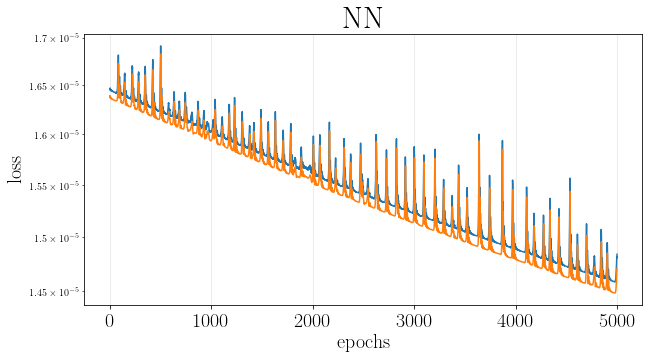

In [132]:
plt.figure(figsize = (10,5))
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

In [126]:
x0 = np.array([[0.0, 0.1],[0.0, 0.2],[0.0, 0.3],[0.0, 0.4],[0.0, 0.5],[0.0, 0.6],[0.1, 0.],[0.2, 0.],[0.3, 0.],[0.4, 0.],[0.5, 0.]])

iterations = [model(x0)[0]]
for _ in range(100):
    iterations.append(model(iterations[-1])[0])

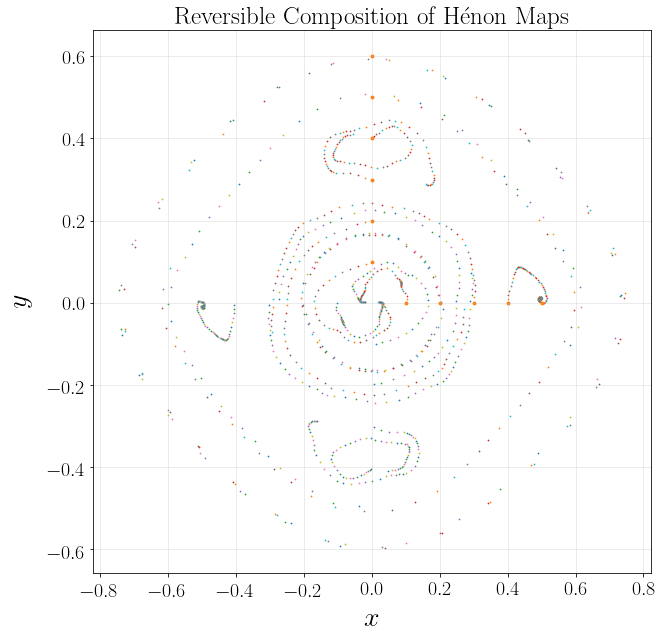

In [127]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'Reversible Composition of H\'enon Maps', fontsize = 25)

for i in iterations:
    plt.scatter(*zip(*i.numpy()), s=3, linewidth=0)
    
plt.scatter(*zip(*x0), s=15, linewidth=0)

#plt.scatter([i[0] for i in Poincare_points], [i[1] for i in Poincare_points], linewidth = 0, s=2)

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
plt.show()

In [128]:
x0 = np.array([[rd.randrange(250, 300, 1)*0.001, rd.randrange(250, 300, 1)*0.001] for _ in range(100)])

f_iterations = [model(x0)[0]]
for _ in range(100):
    f_iterations.append(model(f_iterations[-1])[0])

b_iterations = [f_iterations[-1]*np.array([[1., -1.]])[0]]

for _ in range(100):
    b_iterations.append(model(b_iterations[-1])[0])

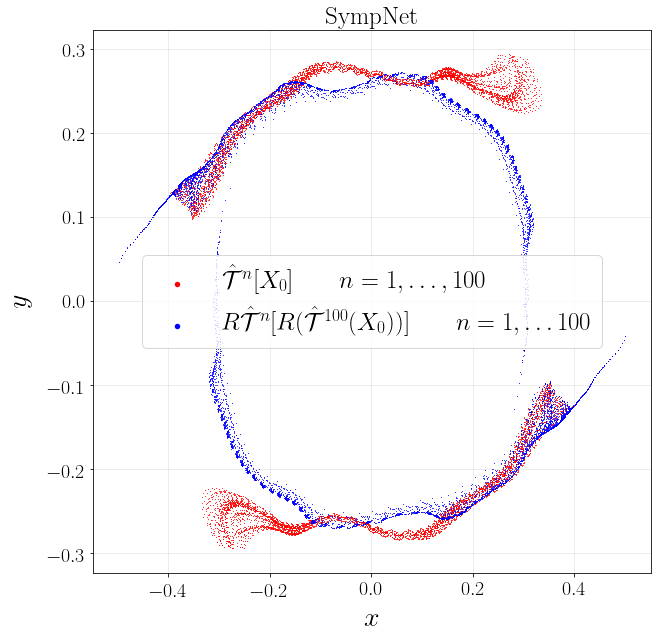

In [129]:
plt.figure(figsize=(10,10))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'SympNet', fontsize = 25)


plt.scatter(*zip(*f_iterations[0].numpy()), s=1, linewidth=0, color='r', label= r'$\hat{\mathcal{T}}^{n}[X_{0}] \qquad n=1,\dots ,100$')

for i in f_iterations:
    plt.scatter(*zip(*i.numpy()), s=1, linewidth=0, color='r')
    
#plt.scatter(*zip(*f_iterations[-1].numpy()), s=15, linewidth=0, color='r')

#plt.scatter(*zip(*b_iterations[0].numpy()), s=15, linewidth=0, color='b')

b_iterations_symm = b_iterations*np.array([[1., -1.]])

plt.scatter(*zip(*b_iterations_symm[0]), s=1, linewidth=0, color='b', label= r'$R \hat{\mathcal{T}}^{n}[R(\hat{\mathcal{T}}^{100}(X_{0}))] \qquad n=1,\dots 100$')

for i in b_iterations_symm:
    plt.scatter(*zip(*i), s=1, linewidth=0, color='b')

plt.xlabel(r'$x$', fontsize=28, labelpad=8)
plt.ylabel(r'$y$', fontsize=28, labelpad=15)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
lgnd = plt.legend(scatterpoints=1, fontsize=25)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
#plt.savefig("Testing_Reversinility_NonReversible.png")
plt.show()

---------------------------------
---------------------------------
---------------------------------

In [267]:
class Rev(tf.keras.Model):
    
    def __init__(self):
            super(Rev, self).__init__()
                    
            self.A1 = tf.keras.layers.Dense(50, activation='selu')
            self.A2 = tf.keras.layers.Dense(100, activation='selu')
            self.A3 = tf.keras.layers.Dense(100, activation='selu')
            self.A4 = tf.keras.layers.Dense(1, activation='selu')
            
            self.a4 = tf.keras.layers.Dense(50, activation='selu')
            self.a3 = tf.keras.layers.Dense(100, activation='selu')
            self.a2 = tf.keras.layers.Dense(100, activation='selu')
            self.a1 = tf.keras.layers.Dense(1, activation='selu')
            
    def call(self, input_tensor):  #, training=False):
        
            ###
            
            A = self.A1(input_tensor)
            A = self.A2(A)
            A = self.A3(A)
            A = self.A4(A)
            
            ###
            
            a = self.a4(A)
            a = self.a3(a)
            a = self.a2(a)
            a = self.a1(a)
            
            out = a - input_tensor
            
            return out

In [268]:
model = Rev()

In [269]:
model.compile(
    loss= tf.keras.losses.MeanSquaredError(),
    #loss = custom_loss,
    #optimizer=tfps.optimizers.bfgs_minimize(), #clipvalue = 0.001),
    #optimizer=keras.optimizers.SGD(0.00001), #, clipvalue = 0.001),
    optimizer=keras.optimizers.Adam(0.001), #, clipvalue = 0.001),
    metrics=["accuracy"],
)

In [270]:
x_train = tf.constant([[rd.random()] for i in range(100000)])

In [271]:
history = model.fit(x_train, a_train, validation_split=0.1, batch_size = 100000, epochs = 1000, callbacks=[callback],  verbose=0) #np.array(x), [np.array(y),a,a]

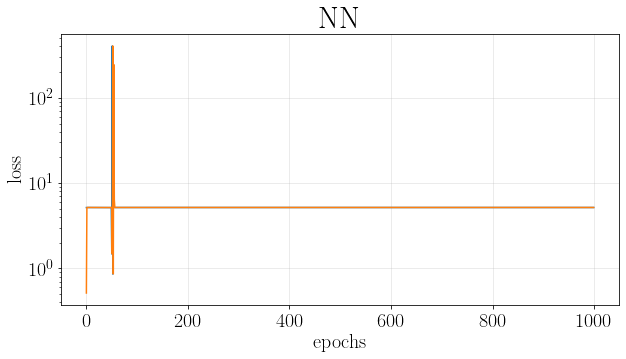

In [272]:
plt.figure(figsize = (10,5))
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

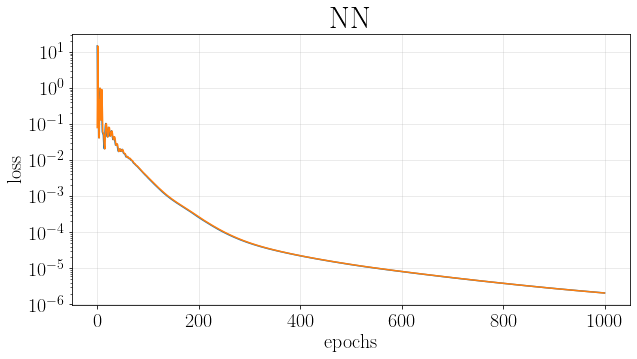

In [265]:
plt.figure(figsize = (10,5))
plt.plot(history.history["val_loss"])
plt.plot(history.history["loss"])
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title(r'NN', fontsize = 30)
plt.xlabel(r'epochs', fontsize=20)
plt.ylabel(r'loss', fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(axis='both', alpha=.3)
#plt.savefig("loss_Henon_E01667")

In [266]:
tf.keras.backend.set_floatx('float32')